In [144]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 

In [145]:
df = pd.read_csv('daily-min-temperatures.csv', header=0, parse_dates=[0])

In [146]:
df.head(10)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


In [147]:
df.dtypes

Date    datetime64[ns]
Temp           float64
dtype: object

In [148]:
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [149]:
df.shape

(3650, 2)

# Creating Y variable

In [150]:
df['t'] = df['Temp'].shift(1)

In [151]:
train,test = df[1:df.shape[0]-7], df[df.shape[0]-7:]

In [152]:
test.head()

,Date,Temp,t
3643,1990-12-25,12.9,10.0
3644,1990-12-26,14.6,12.9
3645,1990-12-27,14.0,14.6
3646,1990-12-28,13.6,14.0
3647,1990-12-29,13.5,13.6


In [153]:
train_X, train_y = train['t'], train['Temp']
test_X, test_y = test['t'], test['Temp']

# Naive forecast: we can assume that last period value is forecast for this value

![](pic1.png)

In [154]:
predictions = test_X.copy()

In [155]:
print(predictions)
print(test_y)

3643    10.0
3644    12.9
3645    14.6
3646    14.0
3647    13.6
3648    13.5
3649    15.7
Name: t, dtype: float64
3643    12.9
3644    14.6
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: Temp, dtype: float64


# Errors in our predictions

In [156]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, predictions)
mse

3.4228571428571413

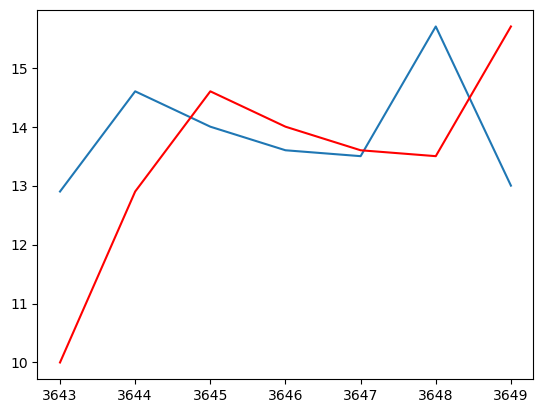

In [157]:
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')

# Autoregression Model: 

In [158]:
prediction = test_X.copy()

In [159]:
from statsmodels.tsa.ar_model import AutoReg

In [160]:
lags=29

In [161]:
model = AutoReg(train['Temp'],lags=lags)
model_fit = model.fit()

In [162]:
# coeff of lag variables
model_fit.params

const       0.557544
Temp.L1     0.588595
Temp.L2    -0.090826
Temp.L3     0.048262
Temp.L4     0.040065
Temp.L5     0.039302
Temp.L6     0.025946
Temp.L7     0.044668
Temp.L8     0.012768
Temp.L9     0.037436
Temp.L10   -0.000812
Temp.L11    0.004791
Temp.L12    0.018473
Temp.L13    0.026891
Temp.L14    0.000576
Temp.L15    0.024810
Temp.L16    0.007403
Temp.L17    0.009916
Temp.L18    0.034160
Temp.L19   -0.009120
Temp.L20    0.024213
Temp.L21    0.018787
Temp.L22    0.012184
Temp.L23   -0.018553
Temp.L24   -0.001772
Temp.L25    0.016732
Temp.L26    0.019762
Temp.L27    0.009832
Temp.L28    0.006227
Temp.L29   -0.001377
dtype: float64

In [163]:
# Get the number of lag variables used in the model
num_lags = len(model_fit.params) - 1
print("Number of lag variables (k_ar):", num_lags)

Number of lag variables (k_ar): 29


In [164]:
# make predictions
prediction = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
prediction

3643    13.053794
3644    13.532591
3645    13.243126
3646    13.091438
3647    13.146989
3648    13.176153
3649          NaN
dtype: float64

In [165]:
prediction.iloc[0]

13.053794217229832

In [166]:
print(test_y)

3643    12.9
3644    14.6
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: Temp, dtype: float64


In [167]:
print(prediction)

3643    13.053794
3644    13.532591
3645    13.243126
3646    13.091438
3647    13.146989
3648    13.176153
3649          NaN
dtype: float64


In [168]:
# Drop rows with NaN values
test_y = test_y.dropna()
prediction = prediction.dropna()

In [169]:
# Align the series based on their indices
test_y, prediction = test_y.align(prediction, join='inner')

In [170]:
msee = mean_squared_error(test_y,prediction)
msee

1.4148209722581406

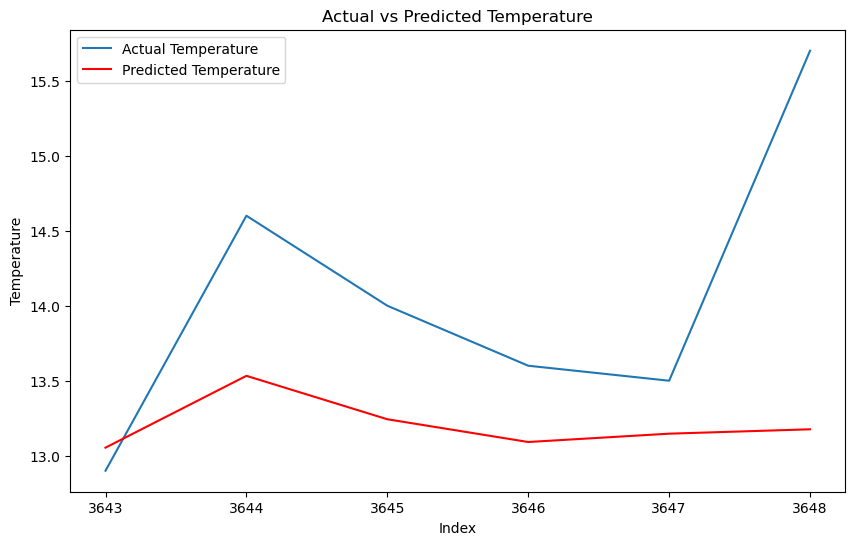

In [171]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual Temperature')
plt.plot(prediction, color='red', label='Predicted Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

# Walk forward Validation for Autoregression

In [172]:
data = train['Temp']
predict = []
for t in range(len(test)):
    model = AutoReg(data,lags=lags)
    model_fit = model.fit()
    ya = model_fit.predict(start=len(data), end=len(data)+len(data)-1, dynamic=False)
    print(ya.values[0])
    predict.append(ya.values[0])
    data=np.append(data,test.iloc[t]['Temp'])
    data= pd.Series(data)

13.053794217229832
13.660699943835198
14.35316414409017
13.430120791627003
13.374756477185121
13.47911129942051
14.767773018439863


In [173]:
predict

[13.053794217229832,
 13.660699943835198,
 14.35316414409017,
 13.430120791627003,
 13.374756477185121,
 13.47911129942051,
 14.767773018439863]

In [174]:
mseee = mean_squared_error(test['Temp'], predict)
print("Mean Squared Error:", mseee)

Mean Squared Error: 1.3046535885665196


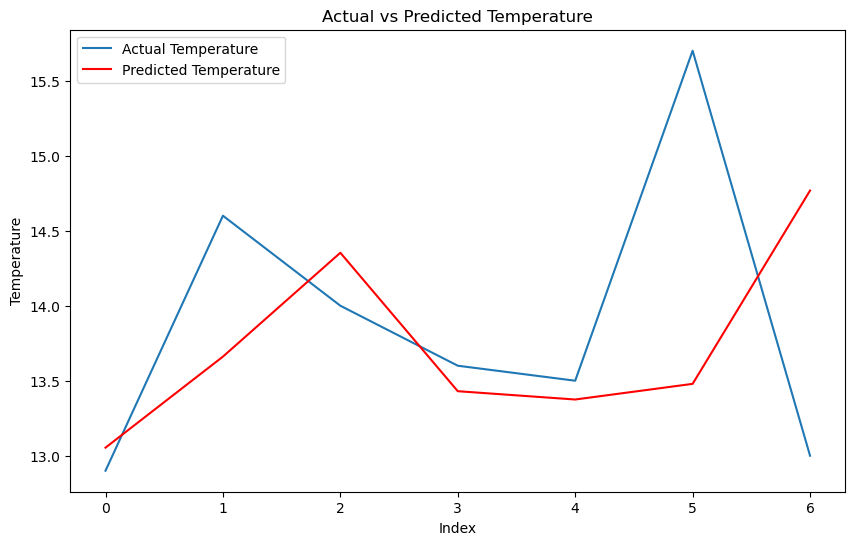

In [176]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(test['Temp'].values, label='Actual Temperature')
plt.plot(predict, color='red', label='Predicted Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()